In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import trim_mean

## Checklist Diagnostik Awal

control -> n=495, skew=19.24, outliers(IQR)=41
treatment -> n=515, skew=6.00, outliers(IQR)=44


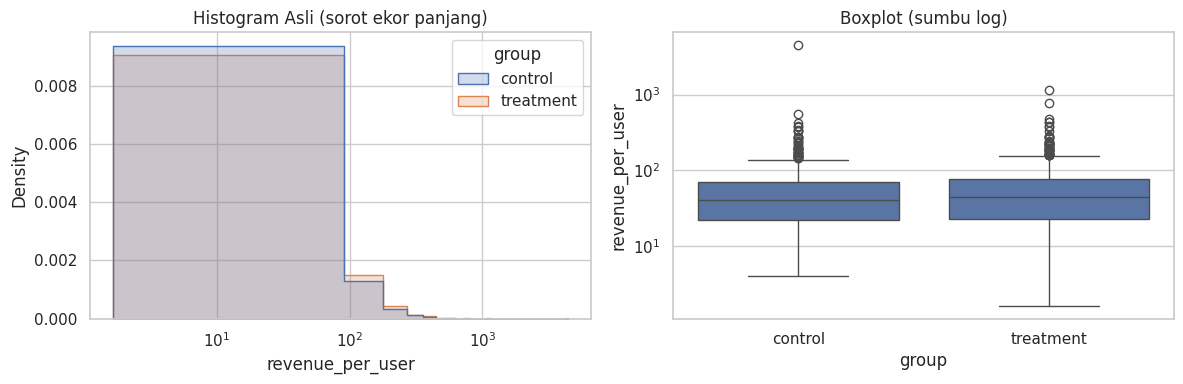

In [2]:
# Data sintetis dari studi kasus A/B e-commerce
rng = np.random.default_rng(42)
n_control, n_treat = 500, 520
mu_control, sigma = 3.70, 0.90
mu_treat = 3.78

# Buat data log-normal yang skew
control = rng.lognormal(mean=mu_control, sigma=sigma, size=n_control)
treat = rng.lognormal(mean=mu_treat, sigma=sigma, size=n_treat)
# Tambahkan "whales" (outlier ekstrem)
control[rng.choice(n_control, size=max(1, n_control//100), replace=False)] *= 8
treat[rng.choice(n_treat, size=max(1, n_treat//100), replace=False)] *= 8

df = pd.DataFrame({
    "group": (["control"]*n_control) + (["treatment"]*n_treat),
    "revenue_per_user": np.concatenate([control, treat]),
})
# Tambahkan beberapa nilai NA untuk simulasi data kotor
df.loc[rng.choice(df.index, size=max(1, len(df)//100), replace=False), "revenue_per_user"] = np.nan

# 1) Bersihkan NA pada metrik utama
d = df.dropna(subset=["revenue_per_user"]).copy()

# 2) Hitung skewness dan outlier IQR
def iqr_outlier_count(x, k=1.5):
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    return np.sum((x < lo) | (x > hi))

for g, sub in d.groupby("group"):
    x = sub["revenue_per_user"].values
    print(f"{g} -> n={len(x)}, skew={stats.skew(x):.2f}, outliers(IQR)={iqr_outlier_count(x)}")

# 3) Visualisasi
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(data=d, x="revenue_per_user", hue="group", bins=50, ax=axes[0],
             element="step", stat="density", common_norm=False)
axes[0].set_title("Histogram Asli (sorot ekor panjang)")
axes[0].set_xscale("log") 

sns.boxplot(data=d, x="group", y="revenue_per_user", ax=axes[1])
axes[1].set_yscale("log")
axes[1].set_title("Boxplot (sumbu log)")
plt.tight_layout()
plt.show()


## Praktik Transformasi yang Benar

In [3]:
# Transformasi
d["rev_log1p"] = np.log1p(d["revenue_per_user"]) 

# 4) Uji Homogenitas Varians (Brown–Forsythe)
lev_orig = stats.levene(d.loc[d.group=="control","revenue_per_user"],
                        d.loc[d.group=="treatment","revenue_per_user"],
                        center="median")
lev_log = stats.levene(d.loc[d.group=="control","rev_log1p"],
                       d.loc[d.group=="treatment","rev_log1p"],
                       center="median")
print(f"Brown–Forsythe (asli): p = {lev_orig.pvalue:.4f}")
print(f"Brown–Forsythe (log1p): p = {lev_log.pvalue:.4f} -> Varian lebih stabil")

# Welch’s t-test pada data asli vs. log-transformasi
x_c_log = d.loc[d.group=="control", "rev_log1p"]
x_t_log = d.loc[d.group=="treatment", "rev_log1p"]
t_log = stats.ttest_ind(x_c_log, x_t_log, equal_var=False)
print(f"Welch t-test (log1p): t = {t_log.statistic:.3f}, p = {t_log.pvalue:.4f}")


Brown–Forsythe (asli): p = 0.7559
Brown–Forsythe (log1p): p = 0.4924 -> Varian lebih stabil
Welch t-test (log1p): t = -0.939, p = 0.3480


## Praktik Robust dengan Bootstrapping

In [6]:
def bootstrap_trimmed_mean_diff(a, b, prop=0.2, n_boot=5000, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    diffs = np.empty(n_boot)
    n_a, n_b = len(a), len(b)
    for i in range(n_boot):
        sa = rng.choice(a, size=n_a, replace=True)
        sb = rng.choice(b, size=n_b, replace=True)
        tm_a = trim_mean(sa, proportiontocut=prop)
        tm_b = trim_mean(sb, proportiontocut=prop)
        diffs[i] = tm_b - tm_a
    ci = np.percentile(diffs, [2.5, 97.5])
    return diffs, ci

# Ambil data asli (bukan yang ditransformasi)
x_c = d.loc[d.group=="control", "revenue_per_user"].values
x_t = d.loc[d.group=="treatment", "revenue_per_user"].values

diffs, ci = bootstrap_trimmed_mean_diff(x_c, x_t, prop=0.2, n_boot=5000, rng=rng)
print(f"Bootstrap 20% trimmed mean diff (treatment - control): "
      f"median={np.median(diffs):.2f}, CI 95%=[{ci[0]:.2f}, {ci[1]:.2f}]")


Bootstrap 20% trimmed mean diff (treatment - control): median=3.43, CI 95%=[-1.60, 8.77]


## Visualisasi Distribusi Bootstrap

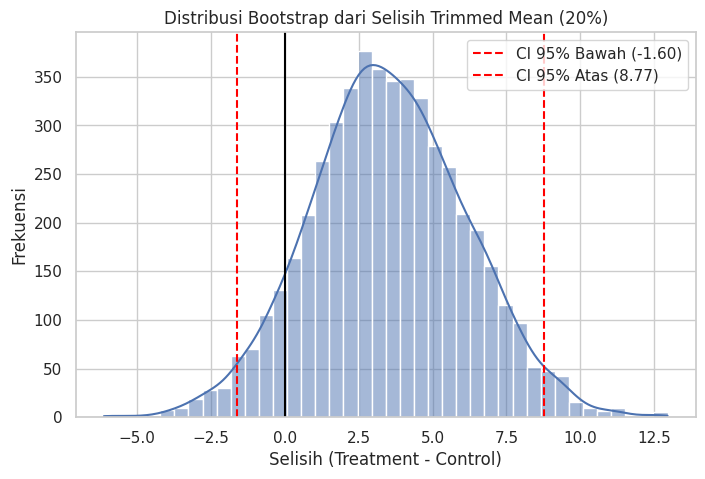

In [7]:
# Visualisasi hasil bootstrap
plt.figure(figsize=(8, 5))
sns.histplot(diffs, bins=40, kde=True)
plt.axvline(ci[0], color='red', linestyle='--', label=f'CI 95% Bawah ({ci[0]:.2f})')
plt.axvline(ci[1], color='red', linestyle='--', label=f'CI 95% Atas ({ci[1]:.2f})')
plt.axvline(0, color='black', linestyle='-')
plt.title('Distribusi Bootstrap dari Selisih Trimmed Mean (20%)')
plt.xlabel('Selisih (Treatment - Control)')
plt.ylabel('Frekuensi')
plt.legend()
plt.show()
